## Prerequisites

In [1]:
from datasets import keepcontrol
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [18]:
# Global variables
PATH = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata"
DEMOGRAPHICS_FILE = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata/participants.tsv"
TRACKED_POINTS = ["left_ankle", "right_ankle"]
CLASSIFICATION_TASK = "phases"
WIN_LEN = 400

## Get the data

In [19]:
ds_train, ds_val, ds_test = keepcontrol.load_data(
    path=PATH,
    filename=DEMOGRAPHICS_FILE,
    tracked_points=TRACKED_POINTS,
    incl_magn=False,
    classification_task=CLASSIFICATION_TASK,
    win_len=WIN_LEN
)

Load dataset from pickle ...


In [20]:
# Split datasets in data and labels
(train_data, train_labels, train_filenames, train_ids) = ds_train
(val_data, val_labels, val_filenames, val_ids) = ds_val

In [21]:
# Shape: (batch_size, win_len, num_channels)
print(f"Shape of train data: {train_data.shape}")
print(f"Shape of train labels: {train_labels.shape}")
print(f"Shape of val data: {val_data.shape}")
print(f"Shape of val labels: {val_labels.shape}")

Shape of train data: (3502, 400, 6)
Shape of train labels: (3502, 400, 1)
Shape of val data: (714, 400, 6)
Shape of val labels: (714, 400, 1)


## Explore the data

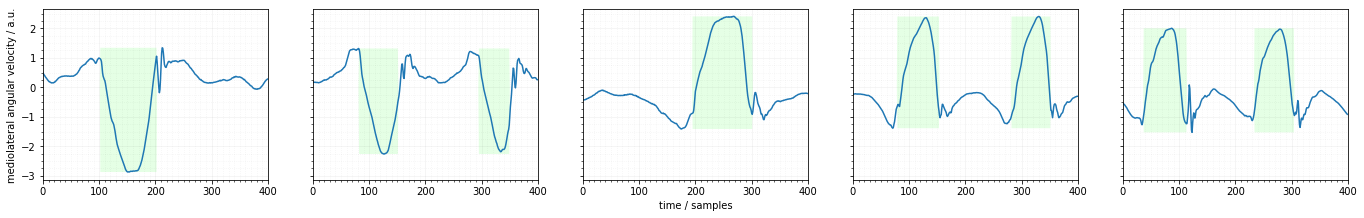

In [46]:
num_examples = 5
indx_random = np.random.choice(train_data.shape[0], num_examples, replace=False)
cm = 1/2.54
fig, axs = plt.subplots(1, num_examples, figsize=(2*29.7*cm, 8*cm), sharey=True)
for (i, indx) in enumerate(indx_random):
    axs[i].fill_between(np.arange(train_labels[indx].shape[0]), train_labels[indx][:,0]*max(train_data[indx][:,5]), color=(0, 1, 0), alpha=0.1, edgecolor='none')
    axs[i].fill_between(np.arange(train_labels[indx].shape[0]), train_labels[indx][:,0]*min(train_data[indx][:,5]), color=(0, 1, 0), alpha=0.1, edgecolor='none')
    axs[i].plot(train_data[indx][:,5])
    axs[i].xaxis.set_minor_locator(plt.MultipleLocator(10))
    axs[i].yaxis.set_minor_locator(plt.MultipleLocator(0.25))
    axs[i].grid(True, which="minor", ls=":", color=(0, 0, 0), alpha=0.05)
    axs[i].grid(True, which="major", color=(0, 0, 0), alpha=0.05)
    axs[i].set_xlim((0, train_data[indx].shape[0]))
axs[0].set_ylabel("mediolateral angular velocity / a.u.")
axs[num_examples//2].set_xlabel("time / samples")
plt.show()

## Build model

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense
from tcn import TCN, tcn_full_summary

In [15]:
def make_model(input_shape):
    
    # Define the layers that make up the architecture
    input_layer = Input(shape=(None, input_shape[-1]), name="input_layer")
    tcn_layer = TCN(
        nb_filters=16,
        kernel_size=3,
        nb_stacks=1,
        dilations=(1, 2, 4, 8, 16, 32),
        padding="causal",
        return_sequences=True,
        use_skip_connections=True,
        use_batch_norm=True,
        name="tcn_layer"
    )(input_layer)
    output_layer = Dense(units=2, activation="softmax", name="output_layer")(tcn_layer)
    
    # Define the model
    tcn_model = Model(inputs=input_layer, outputs=output_layer, name="tcn_model")
    
    # Compile the model
    tcn_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.CategoricalCrossentropy()]
    )
    return tcn_model

In [16]:
tcn_model = make_model(train_data.shape[1:])
tcn_model.summary()

Model: "tcn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, None, 6)]         0         
                                                                 
 tcn_layer (TCN)             (None, None, 16)          9808      
                                                                 
 output_layer (Dense)        (None, None, 2)           34        
                                                                 
Total params: 9,842
Trainable params: 9,458
Non-trainable params: 384
_________________________________________________________________


In [17]:
history = tcn_model.fit(
    x=train_data,
    y=train_labels,
    epochs=5,
    batch_size=128,
    validation_data=(val_data, val_labels)
)

Epoch 1/5
28/28 [==============================] - 3s 29ms/step - loss: nan - categorical_crossentropy: nan - val_loss: nan - val_categorical_crossentropy: nan
Epoch 2/5
28/28 [==============================] - 0s 15ms/step - loss: nan - categorical_crossentropy: nan - val_loss: nan - val_categorical_crossentropy: nan
Epoch 3/5
28/28 [==============================] - 0s 16ms/step - loss: nan - categorical_crossentropy: nan - val_loss: nan - val_categorical_crossentropy: nan
Epoch 4/5
28/28 [==============================] - 0s 15ms/step - loss: nan - categorical_crossentropy: nan - val_loss: nan - val_categorical_crossentropy: nan
Epoch 5/5
28/28 [==============================] - 0s 16ms/step - loss: nan - categorical_crossentropy: nan - val_loss: nan - val_categorical_crossentropy: nan
